# The Efficient Frontier - Part I

This week, we are going to learn how to compute the efficient frontier when we have a set of expected returns, volatilities (or variances) and correlations (or covariances). It's a fair question as to how we can get these numbers for the future, but for now, we'll assume that historic returns are a reasonable estimate. In future sections, we'll learn how to improve on it.

Let's start by importing a new dataset. This is the Ken French dataset of the returns of 30 different industry portfolios. 

This datafile has a number of minor problems that we'll sort through as we go:


In [3]:
import pandas as pd
ind = pd.read_csv("data/ind30_m_vw_rets.csv", header=0, index_col=0)/100
ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')

In [4]:
ind.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


In [5]:
ind.columns

Index(['Food ', 'Beer ', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth ',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin  ', 'Other'],
      dtype='object')

Note that the column names have embedded spaces. We can strip out the leading and trailing spaces in the Series by using the `.str.strip` method.

In [6]:
ind.columns = ind.columns.str.strip()

In [7]:
ind.shape

(1110, 30)

This looks good, so let's add the following code to our module for future use:

```python
def get_ind_returns():
    """
    Load and format the Ken French 30 Industry Portfolios Value Weighted Monthly Returns
    """
    ind = pd.read_csv("data/ind30_m_vw_rets.csv", header=0, index_col=0)/100
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind
```

and then test it by loading the module as usual.

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import edhec_risk_kit_107 as erk
ind = erk.get_ind_returns()
ind.shape

(1110, 30)

<Axes: >

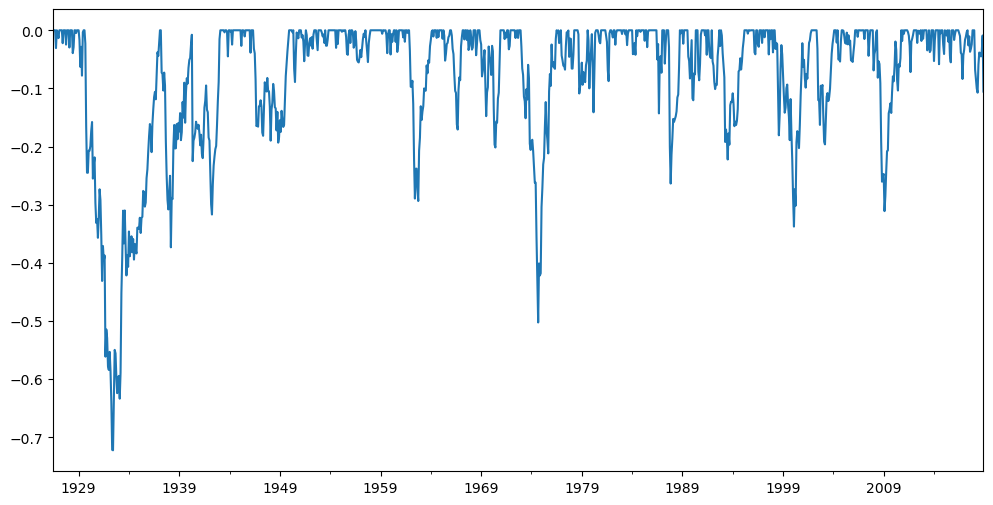

In [9]:
erk.drawdown(ind["Food"])["Drawdown"].plot.line(figsize=(12, 6))

In [10]:
erk.var_gaussian(ind[["Food", "Beer", "Smoke"]], modified=True)

Food     0.061207
Beer     0.033881
Smoke    0.080292
dtype: float64

<Axes: >

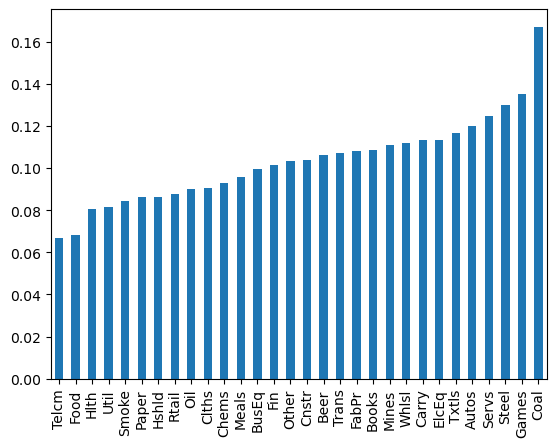

In [11]:
erk.var_gaussian(ind).sort_values().plot.bar()

Let's use this as an opportunity to write functions for annualized returns, volatility and sharpe ratios. Add the following to the `edhec_risk_kit.py` file:

```python
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

```

In [10]:
erk.sharpe_ratio(ind, 0.03, 12).sort_values()

Coal     0.084275
Steel    0.126052
Whlsl    0.143494
Other    0.160862
Mines    0.177109
Books    0.192686
Games    0.194420
Txtls    0.194906
Trans    0.214624
Autos    0.227548
Cnstr    0.229351
FabPr    0.265297
Servs    0.267263
Fin      0.282243
Carry    0.285916
ElcEq    0.293063
Clths    0.293105
Util     0.306945
Hshld    0.307349
Oil      0.330358
Meals    0.332717
BusEq    0.342974
Chems    0.344903
Beer     0.351780
Rtail    0.364325
Paper    0.364722
Telcm    0.383294
Hlth     0.437783
Smoke    0.446361
Food     0.454770
dtype: float64

<Axes: title={'center': 'Industry Sharpe Ratios 1926-2018'}>

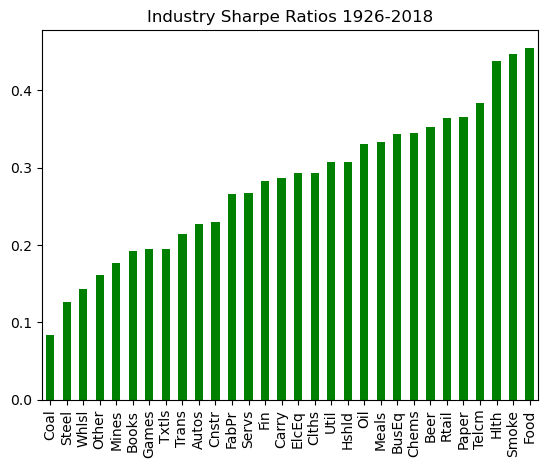

In [14]:
erk.sharpe_ratio(ind, 0.03, 12).sort_values().plot.bar(title="Industry Sharpe Ratios 1926-2018", color="green")

<Axes: title={'center': 'Industry Sharpe Ratios 2000-2018'}>

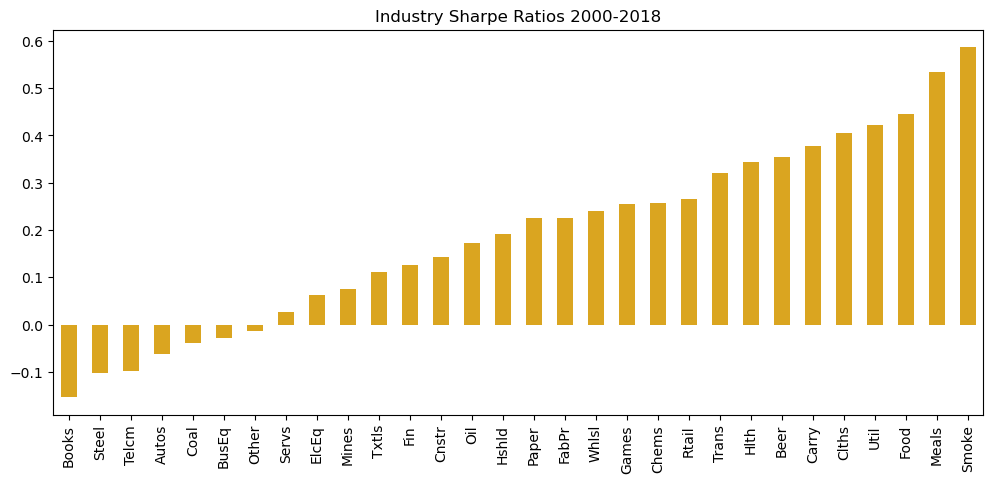

In [17]:
erk.sharpe_ratio(ind["2000":], 0.03, 12).sort_values().plot.bar(title='Industry Sharpe Ratios 2000-2018', figsize=(12,5), color="goldenrod")

## Expected Returns and the Covariance Matrix

Generating the efficient frontier requires a set of expected returns and a covariance matrix. For now, let's assume that we can estiamte these simply by looking back in time and naively assuming they will hold in the future. Clearly, they will not, but we will have plenty of time to dig into that in future lectures. For the moment, assume that our naive method of estimating these parameters will suffice.

We can generate an estimate of expected returns using the `annualize_rets()` function, that returns a vector of expected returns. For instance, let's generate the set of expected returns based on historic returns from the 5 year period from 1996 through 2000:

In [18]:
er = erk.annualize_rets(ind["1995":"2000"], 12)

<Axes: >

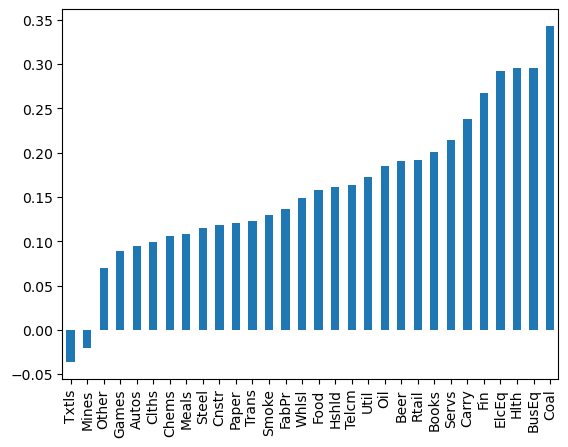

In [19]:
er.sort_values().plot.bar()

Finally, let's generate the covariance matrix. Fortunately, this is easy enough to do using the `.cov` method:

In [20]:
cov = ind["1995":"2000"].cov()
cov.shape

(30, 30)

In the next lab session, we'll take the expected returns vector and the covariance matrix we've constructed and start to plot the efficient frontier!

In [21]:
cov

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Food,0.002287,0.002077,0.001757,0.000701,0.000886,0.001208,0.001474,0.001105,0.001253,0.001021,...,0.000610,0.000211,-0.000280,0.001205,0.001312,0.000633,0.001165,0.001085,0.001839,0.000898
Beer,0.002077,0.004599,0.001143,0.001147,0.000765,0.002447,0.001415,0.001689,0.001292,0.001721,...,0.000978,0.000400,0.000028,0.001455,0.001974,0.000609,0.001442,0.001634,0.002236,0.001196
Smoke,0.001757,0.001143,0.007130,0.000296,-0.000099,0.000981,0.000761,0.000877,0.000687,0.000555,...,0.000057,-0.000266,-0.000300,0.001061,0.000241,0.001363,0.000069,0.000590,0.001117,0.001418
Games,0.000701,0.001147,0.000296,0.003271,0.001485,0.001018,0.001814,0.001219,0.001547,0.001291,...,0.001615,0.002399,0.002935,0.001615,0.001438,0.001681,0.001649,0.001383,0.002080,0.002088
Books,0.000886,0.000765,-0.000099,0.001485,0.002302,0.000876,0.002037,0.000657,0.001559,0.001362,...,0.001627,0.001996,0.001624,0.001481,0.001576,0.001205,0.001995,0.001026,0.001979,0.001283
Hshld,0.001208,0.002447,0.000981,0.001018,0.000876,0.002849,0.001046,0.001253,0.001226,0.001172,...,0.000889,0.001111,0.000906,0.001594,0.001366,0.000578,0.001157,0.001076,0.001652,0.001322
Clths,0.001474,0.001415,0.000761,0.001814,0.002037,0.001046,0.004896,0.000759,0.002547,0.002105,...,0.001263,0.001401,0.000746,0.002683,0.002466,0.001654,0.002607,0.002229,0.002699,0.001974
Hlth,0.001105,0.001689,0.000877,0.001219,0.000657,0.001253,0.000759,0.002252,0.000444,0.000538,...,0.001093,0.001390,0.001264,0.000552,0.000880,0.000907,0.000770,0.000900,0.001412,0.001099
Chems,0.001253,0.001292,0.000687,0.001547,0.001559,0.001226,0.002547,0.000444,0.002944,0.001705,...,0.000860,0.001072,0.000935,0.002581,0.001966,0.001257,0.001661,0.001425,0.002143,0.001832
Txtls,0.001021,0.001721,0.000555,0.001291,0.001362,0.001172,0.002105,0.000538,0.001705,0.002882,...,0.000790,0.000582,0.000685,0.001869,0.001760,0.001426,0.001696,0.001126,0.001789,0.001668
